<a href="https://colab.research.google.com/github/arnavpanda0/Panda-AI/blob/main/Panda-Proj-AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (5110, 12)
['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed    

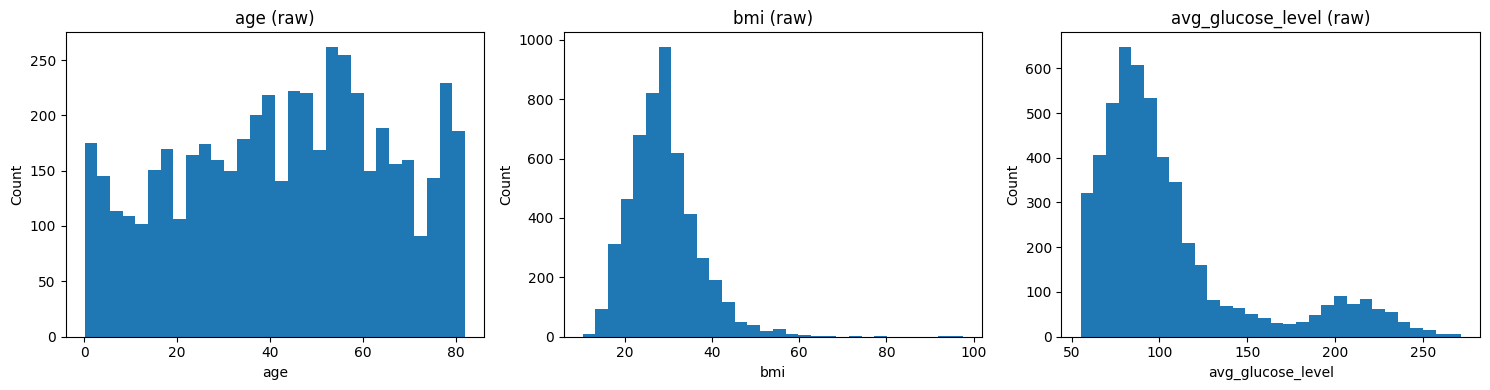

Train shape: (4087, 16) Test shape: (1023, 16)
Train positive rate: 0.04869097137264497 Test positive rate: 0.04887585532746823
After bias: X_train shape: (4087, 17)
Training logistic regression (NumPy) with batch gradient descent...
Iter    1 - cost: 0.693147
Iter  500 - cost: 0.163329
Iter 1000 - cost: 0.157800
Iter 1500 - cost: 0.156225
Iter 2000 - cost: 0.155621
Iter 2500 - cost: 0.155358
Iter 3000 - cost: 0.155235
Training finished.

Final parameters (first 10 shown):
bias (w[0]) = -3.883309
w[1] (age): 1.545207
w[2] (hypertension): 0.140993
w[3] (heart_disease): 0.052189
w[4] (avg_glucose_level): 0.178613
w[5] (bmi): -0.018167
w[6] (gender_Male): 0.027911
w[7] (gender_Other): -0.020455
w[8] (ever_married_Yes): -0.123165
w[9] (work_type_Never_worked): -0.014514
w[10] (work_type_Private): 0.026318
... (17 total weights incl. bias)


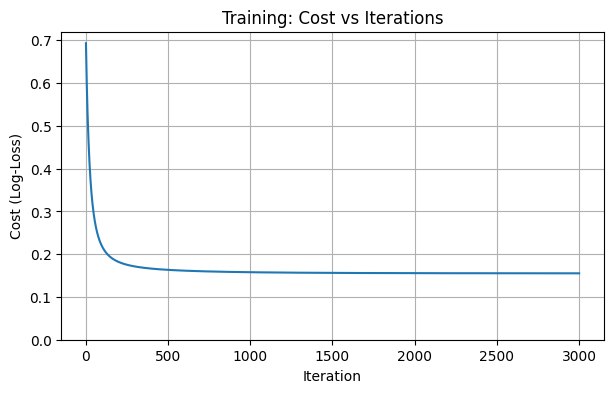


=== Train Metrics ===
Loss (Log-Loss): 0.155235
Accuracy:        0.951309
Precision:       0.000000
Recall:          0.000000
F1-score:        0.000000
Confusion matrix: TP, FP, FN, TN -> 0 0 199 3888

=== Test Metrics ===
Loss (Log-Loss): 0.153952
Accuracy:        0.952102
Precision:       1.000000
Recall:          0.020000
F1-score:        0.039216
Confusion matrix: TP, FP, FN, TN -> 1 0 49 973

Top-3 parameter indices (excluding bias): [1 4 2]


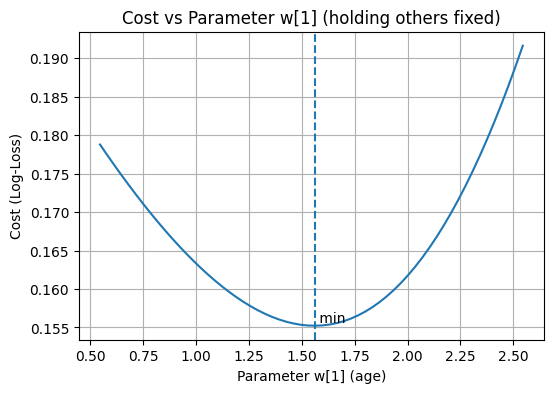

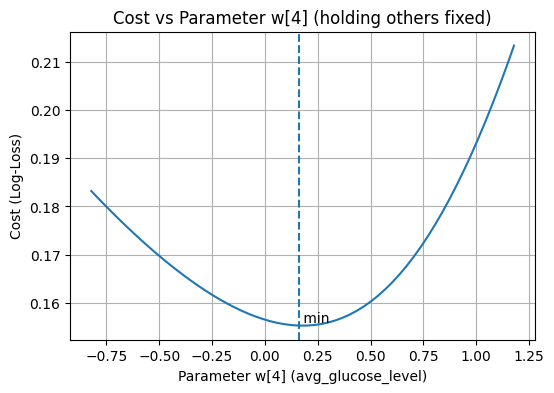

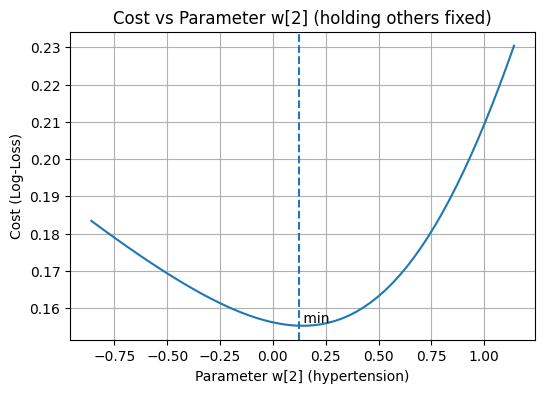


Saved model and preprocessing arrays to current working directory (w_logistic.npy, col_mean.npy, col_std.npy).

Done. Dataset source (mirror): https://raw.githubusercontent.com/NikoletaEm/607LABS/main/healthcare-dataset-stroke-data.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen
import io

np.random.seed(123)

DATA_URL = "https://raw.githubusercontent.com/NikoletaEm/607LABS/main/healthcare-dataset-stroke-data.csv"
print("Downloading dataset from:", DATA_URL)
resp = urlopen(DATA_URL)
csv_bytes = resp.read()
df = pd.read_csv(io.BytesIO(csv_bytes))

print("Dataset shape:", df.shape)
print(df.columns.tolist())
print(df.head())

if 'id' in df.columns:
    df = df.drop(columns=['id'])

if 'stroke' not in df.columns:
    raise ValueError("Expected 'stroke' column in dataset")

if df['bmi'].isnull().any():
    median_bmi = df['bmi'].median()
    df['bmi'] = df['bmi'].fillna(median_bmi)
    print("Imputed missing BMI with median:", median_bmi)

y = df['stroke'].astype(int).to_numpy()
X_df = df.drop(columns=['stroke'])
X_df_raw = X_df.copy()

cat_cols = X_df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [c for c in X_df.columns if c not in cat_cols]
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

if len(cat_cols) > 0:
    X_encoded = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)
else:
    X_encoded = X_df.copy()

feature_names = X_encoded.columns.tolist()
X = X_encoded.to_numpy(dtype=float)
m, n = X.shape
print("After encoding: X shape =", X.shape, "features count =", len(feature_names))

col_mean = X.mean(axis=0, keepdims=True)
col_std  = X.std(axis=0, keepdims=True)
eps = 1e-12
col_std = np.clip(col_std, eps, None)
X_std = (X - col_mean) / col_std

eda_cols = [c for c in ['age', 'bmi', 'avg_glucose_level'] if c in X_df_raw.columns]
if len(eda_cols) > 0:
    ncols = len(eda_cols)
    plt.figure(figsize=(5 * ncols, 4))
    for i, c in enumerate(eda_cols, 1):
        plt.subplot(1, ncols, i)
        plt.hist(X_df_raw[c].dropna(), bins=30)
        plt.title(f'{c} (raw)')
        plt.xlabel(c)
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def stratified_split(X, y, test_size=0.2, seed=123):
    rng = np.random.RandomState(seed)
    classes = np.unique(y)
    train_idx = []
    test_idx  = []
    for c in classes:
        idx_c = np.where(y == c)[0]
        rng.shuffle(idx_c)
        cut = int(np.floor((1 - test_size) * len(idx_c)))
        train_idx.extend(idx_c[:cut].tolist())
        test_idx.extend(idx_c[cut:].tolist())
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)
    return (X[train_idx], X[test_idx], y[train_idx], y[test_idx])

X_train_raw, X_test_raw, y_train, y_test = stratified_split(X_std, y, test_size=0.2, seed=42)
print("Train shape:", X_train_raw.shape, "Test shape:", X_test_raw.shape)
print("Train positive rate:", y_train.mean(), "Test positive rate:", y_test.mean())

def add_bias(X):
    return np.column_stack([np.ones(X.shape[0]), X])

X_train = add_bias(X_train_raw)
X_test  = add_bias(X_test_raw)
m_train, n_with_bias = X_train.shape
print("After bias: X_train shape:", X_train.shape)

def sigmoid(z):
    z_clip = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z_clip))

def predict_proba(X, w):
    return sigmoid(X @ w)

def binary_cross_entropy(y_true, y_prob, eps=1e-12):
    p = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

def gradient(X, y_true, y_prob):
    m_loc = X.shape[0]
    return (X.T @ (y_prob - y_true)) / m_loc

def predict_label(X_new, w, threshold=0.5):
    return (predict_proba(X_new, w) >= threshold).astype(int)

w = np.zeros(n_with_bias, dtype=float)
learning_rate = 0.1
num_iterations = 3000
cost_history = []

print("Training logistic regression (NumPy) with batch gradient descent...")
for t in range(1, num_iterations + 1):
    y_hat = predict_proba(X_train, w)
    cost = binary_cross_entropy(y_train, y_hat)
    cost_history.append(cost)
    grad = gradient(X_train, y_train, y_hat)
    w -= learning_rate * grad

    if t == 1 or t % 500 == 0 or t == num_iterations:
        print(f"Iter {t:4d} - cost: {cost:.6f}")

print("Training finished.")

assert all(c >= -1e-10 for c in cost_history), "Log-loss went negative unexpectedly."

print("\nFinal parameters (first 10 shown):")
print("bias (w[0]) = {:.6f}".format(w[0]))
for i in range(1, min(len(w), 11)):
    print(f"w[{i}] ({feature_names[i-1]}): {w[i]:.6f}")
if len(w) > 11:
    print("... ({} total weights incl. bias)".format(len(w)))

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cost_history)+1), cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost (Log-Loss)")
plt.title("Training: Cost vs Iterations")
plt.ylim(bottom=0)
plt.grid(True)
plt.show()

def classification_report_numpy(XA, yA, w, name=""):
    y_prob = predict_proba(XA, w)
    y_pred = predict_label(XA, w)
    loss = binary_cross_entropy(yA, y_prob)
    acc = (y_pred == yA).mean()
    tp = np.sum((y_pred==1) & (yA==1))
    tn = np.sum((y_pred==0) & (yA==0))
    fp = np.sum((y_pred==1) & (yA==0))
    fn = np.sum((y_pred==0) & (yA==1))
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1  = (2 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0
    print(f"\n=== {name} Metrics ===")
    print(f"Loss (Log-Loss): {loss:.6f}")
    print(f"Accuracy:        {acc:.6f}")
    print(f"Precision:       {prec:.6f}")
    print(f"Recall:          {rec:.6f}")
    print(f"F1-score:        {f1:.6f}")
    print("Confusion matrix: TP, FP, FN, TN ->", tp, fp, fn, tn)
    return {"loss":loss, "accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "tp":tp, "fp":fp, "fn":fn, "tn":tn}

train_stats = classification_report_numpy(X_train, y_train, w, name="Train")
test_stats  = classification_report_numpy(X_test,  y_test,  w, name="Test")

if len(w) > 2:
    param_indices = np.argsort(np.abs(w[1:]))[::-1][:3] + 1
    print("\nTop-3 parameter indices (excluding bias):", param_indices)
    def compute_cost_given_w(mod_w):
        y_hat_mod = predict_proba(X_train, mod_w)
        return binary_cross_entropy(y_train, y_hat_mod)

    for idx in param_indices:
        center = w[idx]
        sweep = np.linspace(center - 1.0, center + 1.0, 60)
        costs = []
        for val in sweep:
            w_tmp = w.copy()
            w_tmp[idx] = val
            costs.append(compute_cost_given_w(w_tmp))
        costs = np.array(costs)
        plt.figure(figsize=(6,4))
        plt.plot(sweep, costs)
        plt.xlabel(f"Parameter w[{idx}] ({feature_names[idx-1]})")
        plt.ylabel("Cost (Log-Loss)")
        plt.title(f"Cost vs Parameter w[{idx}] (holding others fixed)")
        min_i = int(np.argmin(costs))
        plt.axvline(sweep[min_i], linestyle='--')
        plt.text(sweep[min_i], costs[min_i], " min", va='bottom')
        plt.grid(True)
        plt.show()

np.save("w_logistic.npy", w)
np.save("col_mean.npy", col_mean)
np.save("col_std.npy", col_std)
print("\nSaved model and preprocessing arrays to current working directory (w_logistic.npy, col_mean.npy, col_std.npy).")

print("\nDone. Dataset source (mirror):", DATA_URL)
